# Worm Image segmentation

In [2]:
import os
import sys
import tifffile as tiff
import textwrap as tw
import csv
import pandas
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import itertools as IT
import time


import skimage
from skimage import io as skio
from skimage import color


# from skimage import data
# from skimage import img_as_float


# from skimage import filters
# from skimage.util.dtype import dtype_range
# from skimage.util import img_as_ubyte
# from skimage.feature import canny
# from skimage.filters import sobel
# from skimage.morphology import disk, opening, dilation, square, watershed
# from skimage.morphology import erosion, white_tophat, black_tophat, closing
# from skimage import exposure


# from skimage.filters import rank
# from skimage.filters.rank import median, mean
# from skimage import measure
# from skimage.measure import label, regionprops

# #from skimage.filters import threshold_otsu, threshold_adaptive

# #from skimage.feature import peak_local_max
# #from scipy import misc


# import scipy.optimize as opt
# from scipy import ndimage as ndi



sys.path.append("./src")

from utilities import *



## Some adjustments

In [41]:
#matplotlib.use('MacOSX') # For visualising
#matplotlib.use('Agg') # For saving
#matplotlib.use('MacOSX') #TkAgg

plt.interactive(True)
matplotlib.rcParams.update({'font.size': 12})
np.set_printoptions(precision=3)

In [4]:
os.chdir("/home/pnorv/Dropbox/Projects/2015-Metformin/Biolog_Met_NGM/Celegans/")
odir="."

sourceloc = "/home/pnorv/Dropbox/Projects/Metformin_Celegans_Biolog"

## Read threshold  and other information

In [6]:
nutrients = readmet('/home/pnorv/Dropbox/Projects/2015-Metformin/Biolog/Biolog_metabolites_EcoCyc.csv')

alldeletions = readdel('/home/pnorv/Dropbox/Projects/2015-Metformin/Biolog_Met_NGM/Celegans/Deletions.csv')

thresholds_man = readman('/home/pnorv/Dropbox/Projects/2015-Metformin/Biolog_Met_NGM/Celegans/Thresholds_all_3.csv')

cthresholds_man = readman('/home/pnorv/Dropbox/Projects/2015-Metformin/Biolog_Met_NGM/Celegans/Thresholds_Control_manual.csv')

/home/pnorv/Dropbox/Projects/2015-Metformin/Biolog/Biolog_metabolites_EcoCyc.csv
Necessary headers found!
/home/pnorv/Dropbox/Projects/2015-Metformin/Biolog_Met_NGM/Celegans/Deletions.csv
Necessary headers found!
/home/pnorv/Dropbox/Projects/2015-Metformin/Biolog_Met_NGM/Celegans/Thresholds_all_3.csv
Necessary headers found!
/home/pnorv/Dropbox/Projects/2015-Metformin/Biolog_Met_NGM/Celegans/Thresholds_Control_manual.csv
Necessary headers found!


## Test images

### Settings

In [7]:
step = 0.001
levels = ["{0:.3f}".format(lvl) for lvl in np.arange(0, 1 + step, step)]


indo = 0.0

sthres=1000
cthres=0.02

### Select file

In [8]:
files=['Rep6/PM1/PM1_001.tif','Rep5/NGM_Control/NGM_NoMetf_003.tif','Rep5/NGM_Control/NGM_NoMetf_007.tif','Rep5/NGM_Control/NGM_NoMetf_002.tif','Rep6/PM1/PM1_002.tif','Rep6/PM1/PM1_079.tif','Rep4/PM4A/PM4A_054.tif']

fl=files[0]

### Load image

In [35]:
replicate,plate,fln=fl.split('/')
fpat, fname, ftype = filename(fln)
# print plate, fln, row, col
location = "{}/{}".format(sourceloc,fl)

image = tiff.imread(location)

imghsv = color.rgb2hsv(image)
imgrgb = color.hsv2rgb(imghsv)

#Image dimensions
image.shape

(1040, 1392, 3)

### Label worms

In [38]:
h = imghsv[:, :, 0]
v1D = np.around(h.ravel(), 3)
ftable = np.array(freqtable(v1D))
ftable = ftable[np.argsort(ftable[:, 0])]
X, Y, mu, sd = fitgauss(ftable[:, 0], ftable[:, 1])
# What hue threshold o use


#Adjustments depend on the plate
#Hue threshold estimation based on a selection of test images
hthr=mu * 0.995318 + sd * 0.427193 + 0.03


labeled_worms = labeling3(imghsv, hthr,cthres,sthres)


wormind = list(np.unique(labeled_worms))
worms = {w: labeled_worms[labeled_worms == w].shape[0] for w in wormind}
worms = {wk: wp for wk, wp in worms.items() if wp < 1000000}



#Make white background
extract = imgrgb.copy()
extract[labeled_worms == 0, :] = [1, 1, 1]

contours = measure.find_contours(labeled_worms, 0.8)

FWHM: 0.0275575014437, mu: 0.244622725769, SD: 0.0117025933688


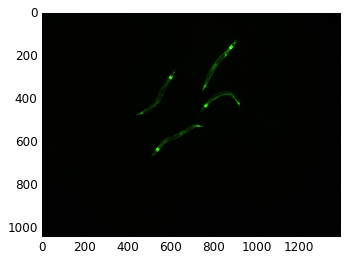

In [44]:
plt.imshow(imgrgb)

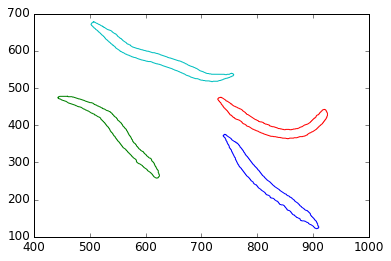

In [37]:
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)

In [43]:
#Plot togetehr
#Does not work for some reason
fig, ax = plt.subplots(num=None, figsize=(20,15), dpi=300, facecolor='w', edgecolor=None,sharex=False,sharey=False)
#plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor=None)
plt.subplots_adjust(bottom=0, left=0 ,hspace=0, wspace=0)

fig.patch.set_visible(False)
ax.axis('off')

plt.imshow(imgrgb)

for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)



ValueError: list.remove(x): x not in list

In [ ]:
# Save the figure
    
# for region in regionprops(labeled_worms):
# 	minr, minc, maxr, maxc = region.bbox
# 	plt.text(maxc, maxr, region.label)

plt.title(ttlw, fontsize=ttlsize)

plt.tight_layout()

fig.savefig(ofignm, pad_inches = 0)#bbox_inches='tight'
plt.close(fig)

## Get examples for plotting

In [ ]:
# ==============================================================================
# #Example picks
# ==============================================================================
# rows=['A','B','C','D','E','F','G','H']

ttllen = 24
ttlsize = 24

minimage = 1
maximage = 96

maxpix = 0

np.set_printoptions(precision=3)

step = 0.001
levels = ["{0:.3f}".format(lvl) for lvl in np.arange(0, 1 + step, step)]


indo = 0.0

sthres=1000
cthres=0.02


#Run through all data using adjustments


files=['Rep6/PM1/PM1_001.tif','Rep5/NGM_Control/NGM_NoMetf_003.tif','Rep5/NGM_Control/NGM_NoMetf_007.tif','Rep5/NGM_Control/NGM_NoMetf_002.tif','Rep6/PM1/PM1_002.tif','Rep6/PM1/PM1_079.tif','Rep4/PM4A/PM4A_054.tif']

#files=['Rep6/PM1/PM1_001.tif']



for fl in files:

	replicate,plate,fln=fl.split('/')
	fpat, fname, ftype = filename(fln)
	# print plate, fln, row, col
	location = "{}/{}".format(sourceloc,fl)

	if plate in ['PM1','PM2A','PM3B','PM4A']:
		mthres = thresholds_man[replicate[3]][plate]
		indx = int(fln.split('_')[1].replace('.tif', ''))
		well = indx2well(indx, start=1)
		metname = nutrients[plate][well]['Metabolite']
		mthr = mthres[indx] if indx in mthres.keys() else ''
		ofignm = '{}/Examples/{}_{}_{}_{}.pdf'.format(odir, replicate, fname, well, metname)

	else:
		mthres = cthresholds_man[replicate[3]][plate]
		indx = int(fln.split('_')[2].replace('.tif', ''))
		well = indx2well(indx, start=1)
		metname=fname
		mthr = mthres[fln] if fln in mthres.keys() else ''
		ofignm = '{}/Examples/{}_{}_{}.pdf'.format(odir, replicate, fname, well)



	print replicate, plate, fln, well


	#indx = flin + 1




	ttl = '{} {}-{} | {}'.format(replicate,indx, well, metname)
	ttlw = '\n'.join(tw.wrap(ttl, ttllen))

	if indx in alldeletions[replicate][plate].keys():
		print 'Deleting some worms!'
		delworms = alldeletions[replicate][plate][indx]['Worms']
	else:
		delworms = []

	image = tiff.imread(location)
	imgclean = wormdel(image, delworms)

	imghsv = color.rgb2hsv(imgclean)
	imgrgb = color.hsv2rgb(imghsv)
	rhead = [replicate, plate, well, fln]


	h = imghsv[:, :, 0]
	v1D = np.around(h.ravel(), 3)
	ftable = np.array(freqtable(v1D))
	ftable = ftable[np.argsort(ftable[:, 0])]
	X, Y, mu, sd = fitgauss(ftable[:, 0], ftable[:, 1])
	# What hue threshold o use


    #Adjustments depend on the plate
    #This was implemented to achieve the best results in terms of worm identification
	if replicate in ['Rep1','Rep2','Rep3','Rep4']:
		hthr=mu * 0.995318 + sd * 0.427193 + 0.020434
	else:
		hthr = mu * 0.995318 + sd * 0.427193 + 0.03


	#Use manual value or estimate
	if mthr!='' and mthr!=0:
		hthres = mthr
	else:
		hthres = hthr



	labeled_worms = labeling3(imghsv, hthres,cthres,sthres)


	wormind = list(np.unique(labeled_worms))
	worms = {w: labeled_worms[labeled_worms == w].shape[0] for w in wormind}
	worms = {wk: wp for wk, wp in worms.items() if wp < 1000000}


	#Make white background
	extract = imgrgb.copy()
	extract[labeled_worms == 0, :] = [1, 1, 1]


	contours = measure.find_contours(labeled_worms, 0.8)

	fig, ax = plt.subplots(num=None, figsize=(20,15), dpi=300, facecolor='w', edgecolor=None,sharex=False,sharey=False)
	#plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor=None)
	plt.subplots_adjust(bottom=0, left=0 ,hspace=0, wspace=0)

	fig.patch.set_visible(False)
	ax.axis('off')

	plt.imshow(imgrgb)

	for n, contour in enumerate(contours):
		plt.plot(contour[:, 1], contour[:, 0], linewidth=1)

	# for region in regionprops(labeled_worms):
	# 	minr, minc, maxr, maxc = region.bbox
	# 	plt.text(maxc, maxr, region.label)

	plt.title(ttlw, fontsize=ttlsize)

	plt.tight_layout()

	fig.savefig(ofignm, pad_inches = 0)#bbox_inches='tight'
	plt.close(fig)  # header=['Replicate','Plate','Well','File','Worm','Brightness_value','Frequency']

## 96-well plate previews

## Read manual adjustments data

In [ ]:
alldeletions = readdel('/home/pnorv/Dropbox/Projects/2015-Metformin/Biolog_Met_NGM/Celegans/Deletions.csv')

thresholds_man = readman('/home/pnorv/Dropbox/Projects/2015-Metformin/Biolog_Met_NGM/Celegans/Thresholds_all_3.csv')

In [ ]:
ttllen = 24
ttlsize = 24

minimage = 1
maximage = 96

maxpix = 0



#plates = ['PM1']
plates=['PM1','PM2A','PM3B','PM4A']
#replicates = ['Rep1', 'Rep2', 'Rep3', 'Rep4','Rep5', 'Rep6']
#replicates = ['Rep1']
#replicates = ['Rep5', 'Rep6']
replicates = ['Rep1', 'Rep2', 'Rep3', 'Rep4','Rep5', 'Rep6']


label = 'auto_threshold'

#File for brightness distributions
ofname = '{}/Summary_{}_{}.csv'.format(odir, 'rep56', label)
#File for thresholds
otname = '{}/Summary_{}_{}.csv'.format(odir, 'thresholds_56', label)


step = 0.001
levels = ["{0:.3f}".format(lvl) for lvl in np.arange(0, 1 + step, step)]


printfigures = True

#Default value for 
sthres=1000
cthres=0.02


data = []
thresholds=[]

#Set which figure you want to plot
# figures=['Original','Labeling']
#figures = ['Original']
figures = ['Labeling']

In [ ]:
#Run through all data using adjustments

#Set index to zero
indo = 0.0
for replicate in replicates:

	platesel = plates[:]
	if replicate == 'Rep4':
		platesel=['PM1','PM3B','PM4A']
	elif replicate == 'Rep5':
		platesel=['PM2A']
	elif replicate == 'Rep6':
		platesel=['PM1','PM2A']

	for plate in platesel:
		mthres = thresholds_man[replicate[3]][plate]

		files = ["{}_{}.tif".format(plate, str(im).zfill(3)) for im in range(1, 96 + 1)]
		total = len(plates) * len(files) * len(replicates)
		figall = []
		axall = []
        #Create figure for plotting 96-well previews
		if printfigures:
			for fi, fign in enumerate(figures):
				fig, axes = plt.subplots(nrows=8, ncols=12, figsize=(72, 47), dpi=300)
				fig.suptitle('{}-{}'.format(replicate, plate), fontsize=40)
				plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=2, wspace=0.5, hspace=0.1)
				figall.append(fig)
				axall.append(axes)
		row = 0
		col = 0

		for flin, fln in enumerate(files):
			fpat, fname, ftype = filename(fln)
			# print plate, fln, row, col
			location = "{}/{}/{}/{}".format(sourceloc, replicate, plate, fln)
			indx = flin + 1
			well = indx2well(flin)
			ttl = '{}-{} | {}'.format(flin + 1, well, nutrients[plate][well]['Metabolite'])
			ttlw = '\n'.join(tw.wrap(ttl, ttllen))

			if indx in alldeletions[replicate][plate].keys():
				print 'Deleting some worms!'
				delworms = alldeletions[replicate][plate][indx]['Worms']
			else:
				delworms = []

			image = tiff.imread(location)
			imgclean = wormdel(image, delworms)

			imghsv = color.rgb2hsv(imgclean)
			imgrgb = color.hsv2rgb(imghsv)
			rhead = [replicate, plate, well, fln]

			if 'Labeling' in figures:
				h = imghsv[:, :, 0]
				v1D = np.around(h.ravel(), 3)
				ftable = np.array(freqtable(v1D))
				ftable = ftable[np.argsort(ftable[:, 0])]
				X, Y, mu, sd = fitgauss(ftable[:, 0], ftable[:, 1])
				# What hue threshold o use

				mthr=mthres[indx] if indx in mthres.keys() else ''

				if replicate in ['Rep1','Rep2','Rep3','Rep4']:
					hthr=mu * 0.995318 + sd * 0.427193 + 0.020434
				else:
					hthr = mu * 0.995318 + sd * 0.427193 + 0.03


				#Use manual value or estimate
				if mthr!='' and mthr!=0:
					hthres = mthr
				else:
					hthres = hthr



				labeled_worms = labeling3(imghsv, hthres,cthres,sthres)


				thresholds.append(rhead+[mu,sd,mthr,hthr])

				wormind = list(np.unique(labeled_worms))
				worms = {w: labeled_worms[labeled_worms == w].shape[0] for w in wormind}
				worms = {wk: wp for wk, wp in worms.items() if wp < 1000000}


				#Make white background
				extract = imgrgb.copy()
				extract[labeled_worms == 0, :] = [1, 1, 1]
				contours = measure.find_contours(labeled_worms, 0.8)

				for w in worms.keys():
					rowhead = [replicate, plate, well, fln, w]
					vw = imghsv[:, :, 2].copy()
					vw[labeled_worms != w] = 0
					bright1D = np.around(vw.ravel(), 3)
					ftable = np.array(freqtable(bright1D))
					ftable = ftable[np.argsort(ftable[:, 0])]
					fdict = {"{0:.3f}".format(freq[0]): int(freq[1]) for freq in ftable}
					values = [fdict[key] if key in fdict.keys() else 0 for key in levels]
					data.append(rowhead + values)


			if printfigures:
				for fi, fign in enumerate(figures):
					fig = figall[fi]
					axes = axall[fi]

					# plt.figure(fi)
					# print row,col
					try:
						plt.sca(axes[row, col])
					except Exception as e:
						print e
						sys.exit(1)
					try:
						ax = axes[row, col]
					except Exception as e:
						print e
						sys.exit(1)
					#ax.axis('off')
					ax.set_adjustable('box-forced')

					if fign == 'Original':
						plt.imshow(imgrgb)
					elif fign == 'Labeling':
						plt.imshow(extract)
						for n, contour in enumerate(contours):
							plt.plot(contour[:, 1], contour[:, 0], linewidth=1)

						for region in regionprops(labeled_worms):
							minr, minc, maxr, maxc = region.bbox
							plt.text(maxc, maxr, region.label)
					else:
						plt.imshow(imgrgb)

					plt.title(ttlw, fontsize=ttlsize)
					plt.setp(ax.get_yticklabels(), visible=False)
					plt.setp(ax.get_xticklabels(), visible=False)

			col = col + 1
			if col == 12:
				col = 0
				row = row + 1

			indo = indo + 1
			prc = (flin + 1) * 100.0 / len(files)
			prco = (indo) * 100.0 / total

			print '{:} {:} {:}:{:6.1f}% | {:6.1f}%'.format(replicate, plate, fname, prc, prco)

		if printfigures:
			for fi, fign in enumerate(figures):
				fig = figall[fi]
				axes = axall[fi]
				# plt.figure(fi)
				fig.tight_layout()

				if fign == 'Original':
					ofignm = '{}/{}_{}_{}.pdf'.format(odir, replicate, plate, fign)
				elif fign == 'Labeling':
					ofignm = '{}/{}_{}_{}_{}.pdf'.format(odir, replicate, plate, label, fign)
				else:
					ofignm = '{}/{}_{}_{}.pdf'.format(odir, replicate, plate, fign)
				fig.savefig(ofignm, bbox_inches='tight')
				plt.close(fig)  # header=['Replicate','Plate','Well','File','Worm','Brightness_value','Frequency']



#Save brightness distributions    
header = ['Replicate', 'Plate', 'Well', 'File', 'Worm'] + levels
data.insert(0, header)
writecsv(data, ofname, '\t')

#Save thresholds
header = ['Replicate', 'Plate', 'Well', 'File', 'Worm'] + ['Mu','SD','Manual_t','Estimated_t']
thresholds.insert(0, header)
writecsv(thresholds, otname, '\t')

## Interactive manual adjustment of thresholds

In [ ]:
# Generate training dataset
# plates = ['PM1', 'PM2A', 'PM3B', 'PM4A']
#
# randset = np.random.randint(13, 97, (4, 4, 3))
# generated = NestedDict()
# for i, iv in enumerate(randset):
# 	for j, jv in enumerate(iv):
# 		if i == 3 and j == 2:
# 			print 'Continue?'
# 			continue
# 		for k in jv:
# 			generated[i + 1][plates[j - 1]][k] = 0
#
# random = readman('Thresholds_6-28_1652_random.csv')

manual = readman('Thresholds_7-14_1539_manual_part3.csv')
tmap = manual
# tmap = generated
# tmap = random

sthres=1000
cthres=0.02

#
# otname = '{}/Thresholds_{}-{}_{}{}_manual.csv'.format(odir, time.localtime().tm_mon, time.localtime().tm_mday,
#                                                       time.localtime().tm_hour, time.localtime().tm_min)
#
# csvout=open(otname,'wb')
# ofile = csv.writer(csvout, delimiter=',')




# header = ['Replicate', 'Plate', 'Index', 'Threshold']
# #data = []
# #data.append(header)
#
# ofile.writerow(header)

#Collect adjustments


nfig = 2
figure, axes = plt.subplots(ncols=nfig, figsize=(8 * nfig, 6), sharex=True,
                            sharey=True)
for fin in [0, 1]:
	ax = axes[fin]
	ax.axis('off')
	ax.set_adjustable('box-forced')

plt.tight_layout()

for rep in tmap.keys():
	#if rep in ['5','6']:
	#	continue
	#a, b, cmin = settings[replicate]
	for pl in tmap[rep].keys():
		mthres = tmap[rep][pl]
		for indx in tmap[rep][pl].keys():

			mthr = mthres[indx] if indx in mthres.keys() else ''
			print 'Manual: {}'.format(mthr)
			if mthr != '' and mthr != 0:
				continue

			print "{} {} {}".format(rep,pl,indx)


			thrs = tmap[rep][pl][indx]


			tfile = "{}/Rep{}/{}/{}_{}.tif".format(sourceloc, rep, pl, pl, str(indx).zfill(3))



			replicate = 'Rep{}'.format(rep)
			if indx in alldeletions[replicate][plate].keys():
				delworms = alldeletions[replicate][plate][indx]['Worms']
			else:
				delworms = []
			image = tiff.imread(tfile)
			image_clean = wormdel(image, delworms)
			imghsv = color.rgb2hsv(image_clean)
			imgrgb = color.hsv2rgb(imghsv)
			h = imghsv[:, :, 0]
			#s = imghsv[:, :, 1]
			#v = imghsv[:, :, 2]


			v1D = np.around(h.ravel(), 3)
			ftable = np.array(freqtable(v1D))
			ftable = ftable[np.argsort(ftable[:, 0])]
			X, Y, mu, sd = fitgauss(ftable[:, 0], ftable[:, 1])

			if rep in ['1','2','3','4']:
				hthr=mu * 0.995318 + sd * 0.427193 + 0.020434
			else:
				hthr = mu * 0.995318 + sd * 0.427193 + 0.03


			hthres = hthr

			nfig = 2
			figure.suptitle("Rep{} {}-{} {}".format(rep, pl, indx, indx2well(indx,1,12)))
			ax = axes[0]
			ax.imshow(imgrgb)
			ax.set_title("Original")
			while 1:
				print 'Rendering: {} {} {}...'.format(rep, pl, indx)

				#h = imghsv[:, :, 0]


				labeled_worms = labeling3(imghsv, hthres,cthres,sthres)

				#labeled_worms, hmax, hthres = labeling2(imghsv, a, b, cmin, hmin=hmin)
				contours = measure.find_contours(labeled_worms, 0.2)
				extract = imgrgb.copy()
				extract[labeled_worms == 0, :] = [1, 1, 1]
				ax = axes[1]
				ax.clear()
				ax.axis('off')
				ax.set_adjustable('box-forced')
				ax.imshow(extract)
				for n, contour in enumerate(contours):
					ax.plot(contour[:, 1], contour[:, 0], linewidth=1)
				ax.set_title("H_peak={0:.3f} Hthres={1:.3f}".format(mu, hthres))
				time.sleep(0.05)
				plt.pause(0.0001)
				print 'H_peak={0:.3f}, Hthres={1:.3f}'.format(mu, hthres)
				newthr = raw_input("Good threshold/retry?: ")
				if newthr == "":
					tmap[rep][pl][indx] = hthres
					#ofile.writerow([rep,pl,indx,hthres])
					break
				elif newthr=="q":
					raise StopIteration
				hthres = float(newthr)




#csvout.close()








thresholds = map2table(tmap)
header = ['Replicate', 'Plate', 'Index', 'Threshold']



otname = '{}/Thresholds_{}-{}_{}{}_manual_part4.csv'.format(odir, time.localtime().tm_mon, time.localtime().tm_mday,
                                                      time.localtime().tm_hour, time.localtime().tm_min)
thresholds.insert(0, header)
writecsv(thresholds, otname, ',')






# Data export
step = 0.005
levels = ["{0:.3f}".format(lvl) for lvl in np.arange(0, 1 + step, step)]
data = []
parameters = []
prog = 0
for rep in tmap.keys():
	#a, b, cmin = settings[replicate]
	for pl in tmap[rep].keys():
		for indx in tmap[rep][pl].keys():
			# rep=2
			# pl='PM1'
			# indx=1
			tfile = "{}/Rep{}/{}/{}_{}.tif".format(sourceloc, rep, pl, pl, str(indx).zfill(3))
			replicate = 'Rep{}'.format(rep)
			if indx in alldeletions[replicate][plate].keys():
				delworms = alldeletions[replicate][plate][indx]['Worms']
			else:
				delworms = []
			image = tiff.imread(tfile)
			image_clean = wormdel(image, delworms)
			imghsv = color.rgb2hsv(image_clean)
			imgrgb = color.hsv2rgb(imghsv)
			h = imghsv[:, :, 0]
			#s = imghsv[:, :, 1]
			#v = imghsv[:, :, 2]

			#layer='h'

			rowhead = [rep, pl, indx,indx2well(indx,1,12), 'h', tmap[rep][pl][indx] ]
			v1D = np.around(h.ravel(), 3)
			ftable = np.array(freqtable(v1D))
			ftable = ftable[np.argsort(ftable[:, 0])]

			X, Y, mu, sd = fitgauss(ftable[:, 0], ftable[:, 1])
			values = [mu, sd]
			# fdict = {"{0:.2f}".format(freq[0]): int(freq[1]) for freq in ftable}
			# values = [fdict[key] if key in fdict.keys() else 0 for key in levels]
			data.append(rowhead + values)
			prog += 1
			print prog

odname = '{}/Thresholds_data_{}-{}_{}{}_manual_peaks.csv'.format(odir, time.localtime().tm_mon,
                                                                 time.localtime().tm_mday,
                                                                 time.localtime().tm_hour, time.localtime().tm_min)
header = ['Replicate', 'Plate', 'Index','Well', 'Layer','Threshold'] + ['Mu', 'SD']  # levels
data.insert(0, header)
writecsv(data, odname, '\t')

In [ ]:
#Carnitine

matplotlib.rcParams.update({'font.size': 80})

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(300,160), dpi=300)
fig.suptitle("Carnitine summary")
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0.2, hspace=0.2)


for ri,rep in enumerate([1,2,3,5,6]):
	for ii,indx in enumerate([1,89,24,50]):
		#rep = 1
		pl = 'PM2A'
		#indx = 89
		tfile = "{}/Rep{}/{}/{}_{}.tif".format(sourceloc, rep, pl, pl, str(indx).zfill(3))
		replicate = 'Rep{}'.format(rep)
		well = indx2well(indx,1)

		if indx in alldeletions[replicate][plate].keys():
			delworms = alldeletions[replicate][plate][indx]['Worms']
		else:
			delworms = []
		image = tiff.imread(tfile)
		image_clean = wormdel(image, delworms)
		imghsv = color.rgb2hsv(image_clean)
		imgrgb = color.hsv2rgb(imghsv)

		plt.sca(axes[ii, ri]);
		ax = axes[ii, ri]

		plt.imshow(imgrgb);
		plt.setp(ax.get_yticklabels(), visible=False)
		plt.setp(ax.get_xticklabels(), visible=False)
		ttl= 'Rep{} {}-{} | {}'.format(rep,indx, well, nutrients[pl][well]['Metabolite'])
		plt.title(ttl)


#fig.tight_layout()
fig.savefig('{}/Summary/Summary_carnitine.pdf'.format(odir), bbox_inches='tight')

## Distributions

In [ ]:
rep = 1
pl = 'PM2A'
indx = 89
tfile = "{}/Rep{}/{}/{}_{}.tif".format(sourceloc, rep, pl, pl, str(indx).zfill(3))
replicate = 'Rep{}'.format(rep)
if indx in alldeletions[replicate][plate].keys():
	delworms = alldeletions[replicate][plate][indx]['Worms']
else:
	delworms = []
image = tiff.imread(tfile)
image_clean = wormdel(image, delworms)
imghsv = color.rgb2hsv(image_clean)
imgrgb = color.hsv2rgb(imghsv)
h = imghsv[:, :, 0]
s = imghsv[:, :, 1]
v = imghsv[:, :, 2]

plt.imshow(imgrgb)






step = 0.001
levels = ["{0:.3f}".format(lvl) for lvl in np.arange(0, 1 + step, step)]

v1D = np.around(h.ravel(), 3)
ftable = np.array(freqtable(v1D))
ftable = ftable[np.argsort(ftable[:, 0])]

# This goes to output
fdict = {"{0:.3f}".format(freq[0]): int(freq[1]) for freq in ftable}
values = [fdict[key] if key in fdict.keys() else 0 for key in levels]




xr = ftable[:, 0]
yr = ftable[:, 1]


plt.scatter(xr[1:],yr[1:])


X, Y, mu, sd = fitgauss(xr[1:], yr[1:])

plt.plot(X, Y, '-b')
plt.plot(X, gauss(X, [mu, sd]), '-g')
plt.plot([mu, mu], [0, np.max(Y)], '-r')
plt.plot([mu - sd, mu - sd], [0, np.max(Y)], '--r')
plt.plot([mu + sd, mu + sd], [0, np.max(Y)], '--r')

In [ ]:
hthres = mu * 0.995318 + sd * 0.427193 + 0.020434


labeled_worms= labeling3(imghsv, hthres,0.02,1000)






plt.imshow(imgrgb)


plt.imshow(labeled_worms)

plt.imshow(extract)

# alldeletions=readdel('{}/Deletions.csv'.format(odir))





wormind = list(np.unique(labeled_worms))
worms = {w: labeled_worms[labeled_worms == w].shape[0] for w in wormind}
worms = {wk: wp for wk, wp in worms.items() if wp < 1000000}




#fig, ax = plt.subplots()




import matplotlib.patches as patches



extract = imgrgb.copy()
extract[labeled_worms == 0, :] = [1, 1, 1]
plt.imshow(extract)

contours = measure.find_contours(labeled_worms, 0.8)

for n, contour in enumerate(contours):
	plt.plot(contour[:, 1], contour[:, 0], linewidth=1)


for region in regionprops(labeled_worms):
	minr, minc, maxr, maxc = region.bbox
	plt.text(maxc,maxr,region.label)
	#print region.bbox
	#rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
	#                          fill=False, edgecolor='black', linewidth=1)
	#plt.patch(rect)


for wk in worms.keys():

print worms

imgfilt = imgrgb.copy()
imgfilt[labeled_worms == 0, :] = 0
plt.imshow(imgfilt)

imgfilt[labeled_worms != 3, :] = 0

plt.imshow(h)

hmin = 0.33
# labeled_worms,hmax,hthres=labeling2(imghsv,0.17,0.2711,0.02,hmin=0.34)
# Optimisation?

selected_worms = labeled_worms.copy()
selected_worms[labeled_worms != 3] = 0
selected_worms[labeled_worms == 3] = 1

plt.imshow(selected_worms)

boolworms = selected_worms.astype(bool)
distance = ndi.distance_transform_edt(boolworms)

dist = opening(distance, selem=disk(7))
plt.imshow(dist)

plt.imshow(distance)

local_maxi = peak_local_max(dist, indices=False,
                            footprint=np.ones((3, 3)),
                            labels=boolworms)
plt.imshow(local_maxi)

markers = ndi.label(local_maxi)[0]

np.unique(markers)
plt.imshow(markers)

labels = watershed(-dist, markers, mask=boolworms)
plt.imshow(labels)

h = imghsv[:, :, 0]
s = imghsv[:, :, 1]
v = imghsv[:, :, 2]

plt.imshow(h)
plt.imshow(v)

# Filtering
dh = rank.median(h, disk(3)) / 255.0
dv = rank.median(v, disk(3)) / 255.0

# v=imghsv[:,:,0]

plt.imshow(dh)

hdiff = 0.05
hmin = 0.36
adp = 40

np.max(dh)
hthres = 0.22 * np.max(dh) + 0.25
print hthres

hf = dh.copy()
hf[(hf < 0.33).astype(bool)] = 0
hf = hf / hthres
plt.imshow(hf)

comb = hf * dv
np.max(comb)
plt.imshow(comb)

markers = np.zeros_like(comb)

# Mark background
markers[comb == 0] = 1
markers[comb > 0.02] = 2
plt.imshow(markers)

elevation_map = sobel(v)
plt.imshow(elevation_map)

segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1)
plt.imshow(segmentation)
labeled_worms, _ = ndi.label(segmentation)

plt.imshow(labeled_worms)

imgsel = labeled_worms[400:700, 700:1200]
plt.imshow(imgsel)

distance = ndi.distance_transform_edt(imgsel)
plt.imshow(distance)

local_maxi = peak_local_max(distance, indices=False,
                            footprint=np.ones((3, 3)),
                            labels=imgsel)
plt.imshow(local_maxi)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=imgsel)

plt.imshow(labels)

# labeled_worms=labeling(v,0.02,0.08)

x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
image = np.logical_or(mask_circle1, mask_circle2)

# Canny filter does not work
edges = canny(v)
plt.imshow(edges)

fill_worms = ndi.binary_fill_holes(edges)
plt.imshow(fill_worms)

label_objects, nb_labels = ndi.label(fill_worms)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0
worms_cleaned = mask_sizes[label_objects]

plt.imshow(worms_cleaned)

# Other testing
v = img2hsv[:, :, 2]
# s_v=s_img2hsv[:,:,2]

figs = [imgrgb, v_closing, h_closing, img2hsv, v]
labels = ['Original', 'V_Mask', 'H_Mask', 'Mask', 'Extract']
fig = plot_comparison(figs, labels)


# Adaptive thresholding

# block_size = 25
# binary_adaptive = threshold_adaptive(h, block_size,offset=0.01)#, offset=10
# plt.imshow(binary_adaptive)
# imgrgb_t=imgrgb.copy()
#
#
# imgrgb_t[binary_adaptive,:]=0;
# plt.imshow(imgrgb_t)


# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.imshow(s_v)

# coords = []

def onclick(event):
	global ix, iy
	ix, iy = event.xdata, event.ydata
	print 'x = %d, y = %d' % (ix, iy)

	global coords
	coords.append([ix, iy])

	if len(coords) == 2:
		fig.canvas.mpl_disconnect(cid)

	return coords


cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Rectangle
from matplotlib.patches import Rectangle


class Annotate(object):
	def __init__(self):
		self.ax = plt.gca()
		self.rect = Rectangle((0, 0), 1, 1)
		self.x0 = None
		self.y0 = None
		self.x1 = None
		self.y1 = None
		self.ax.add_patch(self.rect)
		self.ax.figure.canvas.mpl_connect('button_press_event', self.on_press)
		self.ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

	def on_press(self, event):
		print 'press'
		self.x0 = event.xdata
		self.y0 = event.ydata

	def on_release(self, event):
		print 'release'
		self.x1 = event.xdata
		self.y1 = event.ydata
		self.rect.set_width(self.x1 - self.x0)
		self.rect.set_height(self.y1 - self.y0)
		self.rect.set_xy((self.x0, self.y0))
		self.ax.figure.canvas.draw()


a = Annotate()
plt.show()

# refhsv=color.rgb2hsv(ref)

# image.shape
# image.dtype

# plt.imshow(image)
# image = tiff.imread(file)
# lena = misc.lena()
# blurred_l = ndimage.gaussian_filter(lena, 3)
##increase the weight of edges by adding an approximation of the Laplacian:

blur = imghsv[:, :, 2]

filter_blurred_l = ndimage.gaussian_filter(blur, 1)
alpha = 30
sharpened = blur + alpha * (blur - filter_blurred_l)
plt.imshow(sharpened)

vc_size, hc_size = [7, 7]

vmin, vmax, hmin, hmax = [0.05, 1, 0.35, 0.4]
# image.shape
# image.dtype
imghsv = color.rgb2hsv(image)

imgrgb = color.hsv2rgb(imghsv)

h = imghsv[:, :, 0]
# s =imghsv[:,:,1]
v = imghsv[:, :, 2]

vmask = (v > vmin).astype(np.float64);  # Thresholding in the Brightness
vmask = (vmask < vmax).astype(np.float64);

plt.imshow(vmask)

v_closing = closing(vmask, selem=disk(vc_size))
plt.imshow(v_closing)

image = h_closing

filter_blurred_l = ndimage.gaussian_filter(image, 1)
alpha = 30
sharpened = image + alpha * (image - filter_blurred_l)
plt.imshow(sharpened)

# testing

thresholds = [0.02, 1, 0.355, 0.4]
sizes = [7, 7]

minimage = 1
maximage = 96
maxpix = 0
data = []

plot = True
saveimg = True

files = ["PM1_{}.tif".format(str(im).zfill(3)) for im in range(minimage, maximage + 1)]

rowslices = slice_list(files, 8)  # Slice list to 8 row slices

for file in files:
	fpat, fname, ftype = filename(file)
	print file
	location = "{}/{}/{}/{}".format(sourceloc, replicate, plate, file)

	image, v_opening, h_opening, img2hsv, img2rgb = thresholding(location, thresholds, sizes)

	histinfo_o = exposure.histogram(image)
	histinfo_t = exposure.histogram(img2rgb)
	histinfo_t[0][0] = 0

	h = image[:, :, 0]
	s = image[:, :, 1]
	v = image[:, :, 2]

	# h2 =img2[:,:,0]
	# s2 =img2[:,:,1]
	v2 = img2hsv[:, :, 2]

	if plot:
		fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8.27, 11.69), dpi=100)
		fig.suptitle(fname)
		plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0.2, hspace=0.2)

		plt.sca(axes[0, 0]);
		ax = axes[0, 0]
		plt.imshow(image);
		plt.title('Original')
		plt.sca(axes[0, 1]);
		ax = axes[0, 1]
		plt.imshow(v * 10);
		plt.title('Brightness original')
		plt.sca(axes[1, 0]);
		ax = axes[1, 0]
		plt.imshow(img2hsv);
		plt.title('Mask based on hue and brightness')
		plt.sca(axes[1, 1]);
		ax = axes[1, 1]
		plt.imshow(v2);
		plt.title('Extract')

		plt.sca(axes[2, 0]);
		ax = axes[2, 0]
		plt.plot(histinfo_o[1] / 255.0, histinfo_o[0]);
		plt.title("Brightness histogram - Original");
		plt.xlabel("Brightness");
		plt.ylabel("Pixels");
		plt.xlim([0, 0.1])
		plt.sca(axes[2, 1]);
		ax = axes[2, 1]
		plt.plot(histinfo_t[1], histinfo_t[0]);
		plt.title("Brightness histogram - Thresholding");
		plt.xlabel("Brightness");
		plt.ylabel("Pixels");
		plt.xlim([0, 1])

		fig.tight_layout()
		if saveimg:
			fig.savefig('{}/{}_{}_analysis.pdf'.format(odir, replicate, fname), bbox_inches='tight')
		plt.close(fig)

	bright1D = [el for el in list(v2.ravel()) if el > 0]
	if len(bright1D) > maxpix:
		maxpix = len(bright1D)
	row = [fname] + thresholds + sizes + bright1D
	data.append(row)

maxpix

header = ['File', 'Brightness_min', 'Brightness_max', 'Hue_min', 'Hue_max', 'Bright_opening', 'Bright_dilation',
          'Hue_opening', 'Hue_dilation'] + range(1, maxpix + 1)
data.insert(0, header)

ofile = '{}/Summary.csv'.format(odir)

writecsv(data, ofile)

## Mark sick worms interactively

In [ ]:
# def onclick(event):
#    global ix, iy
#    global coords
#    #global worms
#    #coords=[]
#
#    ix, iy = event.xdata, event.ydata
#    print 'x = %d, y = %d'%(ix, iy)
#    coords.append([ix, iy])
#
#    #if len(coords) == 2:
#    fig.canvas.mpl_disconnect(cid)
#                    
#    return coords



deletions = {'Rep1-PM1': [3, 29, 33, 41, 44, 57, 62, 93],
             'Rep1-PM2A': [30, 40, 41, 45, 47, 48, 75],
             'Rep1-PM3B': [10, 31, 33, 41, 90],
             'Rep1-PM4A': [32, 58, 82]}

dfiles = ["{}/{}/{}/{}_{}.tif".format(sourceloc, replicate, plate, plate, str(im).zfill(3)) for im in
          deletions.iteritems()]

thresi = [0.02, 1, 0.345, 0.4]
sizei = [7, 7]

# from matplotlib.patches import Rectangle

deldata = []
plt.ion()  ## Note this correction
for dkey in deletions.keys():
	rep, plate = dkey.split('-')
	dfiles = deletions[dkey]

	thresi, sizei = settings[rep]
	for indx in dfiles:
		dfile = "{}/{}/{}/{}_{}.tif".format(sourceloc, rep, plate, plate, str(indx).zfill(3))
		dname = os.path.basename(dfile)
		well = indx2well(indx)

		print rep, plate, well, dname

		image = tiff.imread(location)
		imghsv = color.rgb2hsv(image)
		imgrgb = color.hsv2rgb(imghsv)

		v_closing, h_closing, img2hsv, img2rgb = thresholding2(imghsv, thresi, sizei, delworms)

		# v=img2hsv[:,:,2]
		# plt.imshow(s_img2hsv[822:964,749:1014,:])
		worms = []
		coords = []
		fig, axes = plot_comparison(imgrgb, img2hsv, 'Pick worms: {}'.format(dname))

		while True:
			# while len(coords)<2:
			coords = plt.ginput(2)
			print coords

			x1, y1 = coords[0]
			x2, y2 = coords[1]

			xs = [x1, x2]
			ys = [y1, y2]

			excordt = [x1, y1, x2, y2]
			excord = [int(c) for c in excordt]

			# ax2=axes[1]
			# ax2.add_patch(Rectangle(( max(xs)- min(xs), max(ys) -min(ys)), 0.2, 0.2,
			#          alpha=0.5, facecolor='none'))
			# fig.canvas.draw()
			# cid = fig.canvas.mpl_connect('button_press_event', onclick)
			# plt.waitforbuttonpress()
			# print coords,cid

			# plt.pause(0.05)
			save = raw_input("Save coordinates (y/n)?: ")
			if save == 'y':
				worms.append(excord)
				coords = []
				multi = raw_input("Mark other worms (y/n)?: ")
				if multi == 'y':
					continue
				else:
					break
			else:
				coords = []
				multi = raw_input("Mark other worm (y/n)?: ")
				if multi == 'y':
					continue
				else:
					break

		headr = [rep, plate, indx, dname]
		for worm in worms:
			deldata.append(headr + worm)
		plt.close(fig)

header = ['Replicate', 'Plate', 'Index', 'File', 'X1', 'Y1', 'X2', 'Y2']
deldata.insert(0, header)

# ofile='{}/Deletions.csv'.format(odir)
# writecsv(deldata,ofile)


##########
# Just get the data
##########

replicate = 'Rep2'
thresi, sizei = settings[replicate]

files = ["{}_{}.tif".format('NGM_NoMetf', str(imid).zfill(3)) for imid in range(1, 9)] + [
	"{}_{}.tif".format('NGM_Metf', str(imid).zfill(3)) for imid in range(1, 9)]
folders = ['Controls_1930', 'Controls_2240']

data = []

# plates=['PM1']
indo = 0.0

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(72, 47), dpi=300)
fig.suptitle('Negative controls', fontsize=40)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=2, wspace=0.5, hspace=0.1)

row = 0
col = 0

for folder in folders:
	# files=["{}_{}.tif".format(plate,str(im).zfill(3)) for im in range(1,96+1)]
	total = len(folders) * len(files)

	for flin, fln in enumerate(files):
		fpat, fname, ftype = filename(fln)
		location = "{}/{}/{}/{}".format(sourceloc, replicate, folder, fln)
		if os.path.exists(location):
			image = tiff.imread(location)
			imghsv = color.rgb2hsv(image)
			imgrgb = color.hsv2rgb(imghsv)
			v_closing, h_closing, img2hsv, img2rgb = thresholding2(imghsv, thresi, sizei, [])

			v2 = img2hsv[:, :, 2]
			bright1D = [el for el in list(v2.ravel()) if el > 0]
			ftable = freqtable(bright1D)
			rowhead = [replicate, folder, fln]  # +thresi+sizei
			for fv in ftable:
				data.append(rowhead + fv)

		try:
			plt.sca(axes[row, col])
		except Exception as e:
			print e
			sys.exit(1)
		try:
			ax = axes[row, col]
		except Exception as e:
			print e
			sys.exit(1)

		plt.imshow(imgrgb)
		if col == 0:
			ax.yaxis.set_label_position("left")
			plt.ylabel('{}_{}'.format(folder, '-'.join(fname.split('_')[0:1])), rotation='vertical')

		col = col + 1
		if col == 8:
			col = 0
			row = row + 1

		indo = indo + 1
		prc = (flin + 1) * 100.0 / len(files)
		prco = (indo) * 100.0 / total
		print '{:} {:} {:}:{:6.1f}% | {:6.1f}%'.format(replicate, plate, fname, prc, prco)

fig.tight_layout()
ofignm = '{}/Negative_Controls_comparison.pdf'.format(odir)
fig.savefig(ofignm, bbox_inches='tight')
plt.close(fig)

header = ['Replicate', 'Folder', 'File', 'Brightness_value', 'Frequency']
data.insert(0, header)
f = open('{}/Summary_{}_{}_{}_Negative_controls.csv'.format(odir, replicate, thrstr, sizestr), "wb")
ofile = csv.writer(f, delimiter='\t')  # dialect='excel',delimiter=';', quotechar='"', quoting=csv.QUOTE_ALL
for row in data:
	# row = [item.encode("utf-8") if isinstance(item, unicode) else str(item) for item in row]
	ofile.writerow(row)
f.close()

# Check controls


replicate = 'Rep2'
folder = 'Controls_1930'
indx = 2
# rfile="{}/{}/NGM_Control_Rep1.tif".format(sourceloc,replicate)
tfile = "{}/{}/{}/{}_{}.tif".format(sourceloc, replicate, folder, 'NGM_NoMetf', str(indx).zfill(3))

thresi, sizei = settings[replicate]

image = tiff.imread(tfile)
imghsv = color.rgb2hsv(image)
imgrgb = color.hsv2rgb(imghsv)

v_closing, h_closing, img2hsv, img2rgb = thresholding2(imghsv, thresi, sizei, [])

# plt.imshow(imgrgb)


plt.imshow(img2hsv)

In [ ]:
# ==============================================================================
# #@#Test parameters
# ==============================================================================

#
# odir='2017-05-17_Trial_analysis2'
#
# sourceloc="2017-05-17_Trial"


replicate = "Rep2"
plate = "PM1"

plate = 'Control_1930'

thresholds, sizes = settings[replicate]
a, b, cmin = settings[replicate]

# hstep=0.01
# hmin=0.3
# hmax=0.4
#
# bstep=0.005
# bmin=0.01
# bmax=0.05



hstep = 0.01
hmin = 0.05
hmax = 0.15

bstep = 0.01
bmin = 0.01
bmax = 0.08

hues = np.arange(hmin, hmax + hstep, hstep)
brights = np.arange(bmin, bmax + bstep, bstep)

totalf = len(brights) * len(hues)

# files=["image_{}.tif".format(str(im).zfill(3)) for im in range(minimage,maximage+1)]

# imid=33


# files=["{}_{}.tif".format(plate,str(im).zfill(3)) for im in range(minimage,maximage+1)]

# filenum=[1,2,9,15,18,28,33,35,61]
filenum = [1, 2, 9, 28, 33]

files = ["{}_{}.tif".format(plate, str(imid).zfill(3)) for imid in filenum]

data = []

sizei = sizes

size_v_closing = [7]
size_h_closing = [7]

overall = len(files) * totalf * len(size_v_closing) * len(size_h_closing)
print overall

indo = 0.0
for svc in size_v_closing:
	sizei[0] = svc
	for shc in size_h_closing:
		sizei[1] = shc
		sizestr = '|'.join([str(sz) for sz in sizei])
		for file in files:
			fpat, fname, ftype = filename(file)
			print file
			location = "{}/{}/{}/{}".format(sourceloc, replicate, plate, file)

			well = indx2well(int(fname.split('_')[1]), start=1)
			fig, axes = plt.subplots(nrows=len(brights), ncols=len(hues), sharex=True, sharey=True, figsize=(40, 24),
			                         dpi=300)
			fig.suptitle('{} - {} | {}'.format(fname, well, nutrients[plate][well]['Metabolite']))
			# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.5, wspace=0, hspace=0)
			ind = 0.0

			image = tiff.imread(location)
			imghsv = color.rgb2hsv(image)
			# imgrgb=color.hsv2rgb(imghsv)

			v = imghsv[:, :, 2]

			for bi, bval in enumerate(brights):
				for hi, hval in enumerate(hues):

					ind = ind + 1.0
					indo = indo + 1.0
					thresi = thresholds
					thresi[0] = bval
					thresi[2] = hval
					thrstr = '|'.join([str(th) for th in thresi])

					indx = int(fname.split('_')[1])
					if indx in alldeletions[replicate][plate].keys():
						print 'Deleting some worms!'
						delworms = alldeletions[replicate][plate][indx]['Worms']
					else:
						delworms = []

					# v_closing,h_closing,img2hsv,img2rgb=thresholding2(imghsv,thresi,sizei,delworms)
					# labeled_worms=labeling(v,bval,hval)
					labeled_worms = labeling2(imghsv, a, b, cmin)

					plt.sca(axes[bi, hi]);
					ax = axes[bi, hi]
					# plt.imshow(img2hsv)
					plt.imshow(labeled_worms)
					plt.setp(ax.get_yticklabels(), visible=False)
					plt.setp(ax.get_xticklabels(), visible=False)

					if hi == 0:
						ax.yaxis.set_label_position("left")
						plt.ylabel(bval, rotation='vertical')
					if bi == 0:
						plt.title(hval)

					prcf = ind * 100.0 / totalf
					prco = indo * 100.0 / overall
					print '{:}:{:6.1f}% |{:6.1f}%'.format(fname, prcf, prco)

			# fig.tight_layout()
			fig.savefig('{}/{}_{}_{}_labeling.pdf'.format(odir, replicate, fname, sizestr), bbox_inches='tight')
			plt.close(fig)